In [1]:
! pip install pandas
! pip install networkx
! pip install matplotlib
! pip install scipy


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import random
from matplotlib import pyplot as plt
import os
from ipyleaflet import Map, TileLayer, CircleMarker

from sklearn.preprocessing import MinMaxScaler

In [3]:
data = pd.read_csv('../Data/2023.csv')

#data = data.dropna() 

data.head(10)

,STARTSTATIONNAME,STARTSTATIONARRONDISSEMENT,STARTSTATIONLATITUDE,STARTSTATIONLONGITUDE,ENDSTATIONNAME,ENDSTATIONARRONDISSEMENT,ENDSTATIONLATITUDE,ENDSTATIONLONGITUDE,STARTTIMEMS,ENDTIMEMS
0,Métro Mont-Royal (Utilités publiques / Rivard),Le Plateau-Mont-Royal,45.524236,-73.581552,Chabot / Mont-Royal,Le Plateau-Mont-Royal,45.534134,-73.573524,1698266696468,1.698267e+12
1,Rielle / Wellington,Verdun,45.460156,-73.567001,St-Jacques / McGill,Ville-Marie,45.501441,-73.560144,1698270535502,1.698272e+12
2,Ste-Catherine / Drummond,Ville-Marie,45.498588,-73.574278,Peel / Ottawa,Le Sud-Ouest,45.494200,-73.559985,1698285705974,1.698286e+12
3,Boyer / du Mont-Royal,Le Plateau-Mont-Royal,45.527432,-73.579917,de l'Hôtel-de-Ville / Rachel,Le Plateau-Mont-Royal,45.519897,-73.580106,1698269489932,1.698270e+12
4,Clark / Ontario,Ville-Marie,45.510625,-73.566903,Wolfe / Robin,Ville-Marie,45.519581,-73.560116,1698270006571,1.698270e+12
5,Bourget / St-Jacques,Le Sud-Ouest,45.480846,-73.583862,Métro Lionel-Groulx (St-Jacques / Atwater),Le Sud-Ouest,45.483629,-73.579703,1698274953294,1.698275e+12
6,St-Antoine / de la Montagne,Ville-Marie,45.495372,-73.568589,Ste-Catherine / St-Mathieu,Ville-Marie,45.493833,-73.579142,1698292627511,1.698293e+12
7,de Maisonneuve / Greene,Westmount,45.486971,-73.589293,Métro Atwater (Atwater / Ste-Catherine),Ville-Marie,45.489476,-73.584566,1698268339505,1.698269e+12
8,Marie-Anne / St-Hubert,Le Plateau-Mont-Royal,45.524683,-73.578897,Marie-Anne / Papineau,Le Plateau-Mont-Royal,45.531774,-73.572446,1698279430752,1.698280e+12
9,Ste-Catherine / St-Laurent,Ville-Marie,45.509813,-73.563895,St-André / Ste-Catherine,Ville-Marie,45.516427,-73.558112,1698277591355,1.698278e+12


In [4]:
G = nx.from_pandas_edgelist(data, 'STARTSTATIONNAME', 'ENDSTATIONNAME')

# nx.write_graphml(G, "2023.graphml")

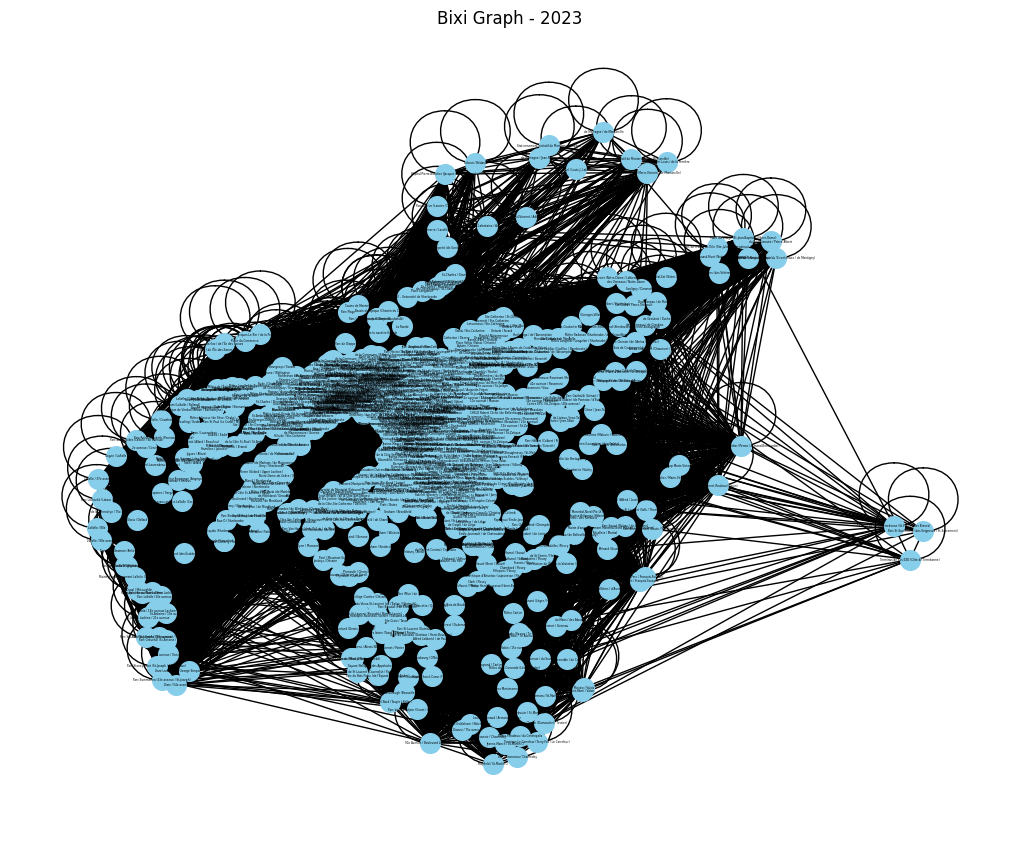

In [5]:


unique_positions_df = data[['STARTSTATIONNAME' , 'STARTSTATIONLATITUDE', 'STARTSTATIONLONGITUDE']].drop_duplicates()

node_positions = {}
nodes_to_remove = []
for node in G.nodes():
    node_data = unique_positions_df.loc[unique_positions_df['STARTSTATIONNAME'] == node]
    if not node_data.empty:
        latitude = node_data.iloc[0]['STARTSTATIONLATITUDE']
        longitude = node_data.iloc[0]['STARTSTATIONLONGITUDE']
        if node == "Smith / Peel": # the coordinate of Smith / Peel is -1/-1 ...
            latitude = 45.500414
            longitude = -73.57371
        node_positions[node] = (latitude, longitude)
    else:
        # handle the case when no coordinate for the node is not found
        nodes_to_remove.append(node)
    
for node in nodes_to_remove:
    G.remove_node(node)

plt.figure(figsize=(10, 8))

nx.draw(G, pos=node_positions, with_labels=True, node_color='skyblue', node_size=200, edge_color='black', linewidths=1, font_size=2)
plt.title('Bixi Graph - 2023')
plt.show()

In [ ]:
# num_nodes_to_visualize = 20
# random_nodes = random.sample(G.nodes(), num_nodes_to_visualize)
# subgraph = G.subgraph(random_nodes)

# # Step 4: Draw the subgraph
# plt.figure(figsize=(10, 8))
# nx.draw(subgraph, with_labels=True, node_color='skyblue', node_size=50, edge_color='black', linewidths=1, font_size=8)
# plt.title(f'{num_nodes_to_visualize} random Bixi stations')
# plt.show()

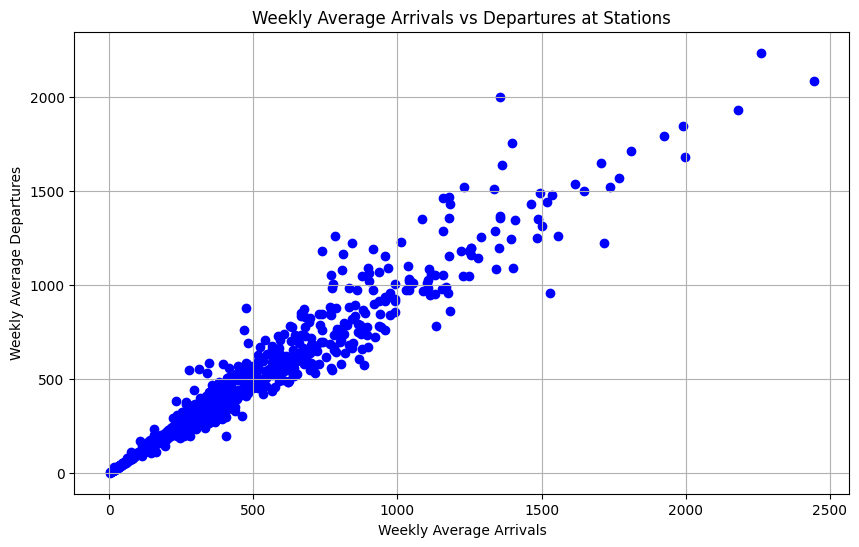

In [7]:
#data = pd.read_csv('../Data/2023.csv')

# Convert STARTTIMEMS and ENDTIMEMS to datetime objects
data['STARTTIMEMS'] = pd.to_datetime(data['STARTTIMEMS'], unit='ms')
data['ENDTIMEMS'] = pd.to_datetime(data['ENDTIMEMS'], unit='ms')

# Extract week number from the STARTTIMEMS column
data['Week'] = data['STARTTIMEMS'].dt.isocalendar().week

# Group by STARTSTATIONNAME and Week to calculate weekly average arrivals and departures
grouped = data.groupby(['STARTSTATIONNAME', 'Week']).size().reset_index(name='Arrivals')
grouped = grouped.groupby('STARTSTATIONNAME')['Arrivals'].mean().reset_index(name='AvgArrivals')

# Group by ENDSTATIONNAME and Week to calculate weekly average departures
grouped_departures = data.groupby(['ENDSTATIONNAME', 'Week']).size().reset_index(name='Departures')
grouped_departures = grouped_departures.groupby('ENDSTATIONNAME')['Departures'].mean().reset_index(name='AvgDepartures')

# Merge average arrivals and departures data
grouped = pd.merge(grouped, grouped_departures, left_on='STARTSTATIONNAME', right_on='ENDSTATIONNAME')

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(grouped['AvgArrivals'], grouped['AvgDepartures'], marker='o', color='b')
plt.xlabel('Weekly Average Arrivals')
plt.ylabel('Weekly Average Departures')
plt.title('Weekly Average Arrivals vs Departures at Stations')
plt.grid(True)
plt.show()

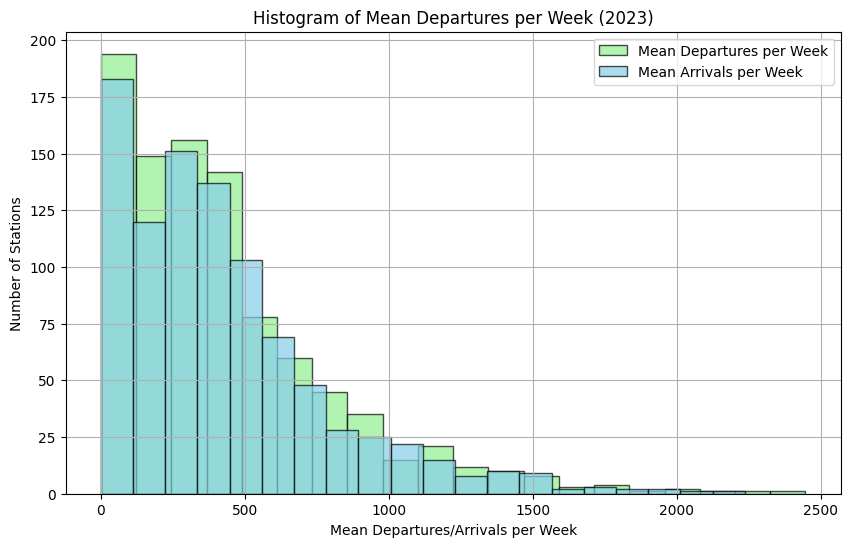

In [52]:
# Convert STARTTIMEMS/ENDTIMEMS to datetime objects
data['STARTTIMEMS'] = pd.to_datetime(data['STARTTIMEMS'], unit='ms')
data['ENDTIMEMS'] = pd.to_datetime(data['ENDTIMEMS'], unit='ms')

# Extract week number from the STARTTIMEMS/ENDTIMEMS column
data['WeekStart'] = data['STARTTIMEMS'].dt.isocalendar().week
data['WeekEnd'] = data['ENDTIMEMS'].dt.isocalendar().week

# Group by STARTSTATIONNAME/ENDSTATIONNAME and Week to compute the count for each station and week
startstation_week_count = data.groupby(['STARTSTATIONNAME', 'WeekStart']).size().reset_index(name='Count')
endstation_week_count = data.groupby(['ENDSTATIONNAME', 'WeekEnd']).size().reset_index(name='Count')

# Calculate the mean count for each station
startstation_mean_count = startstation_week_count.groupby('STARTSTATIONNAME')['Count'].mean().reset_index(name='MeanCount')
endstation_mean_count = endstation_week_count.groupby('ENDSTATIONNAME')['Count'].mean().reset_index(name='MeanCount')
# print(startstation_mean_count)
# Count the number of stations for each mean count
# mean_count_startstations = startstation_mean_count.groupby('MeanCount').size()
# mean_count_endstations = endstation_mean_count.groupby('MeanCount').size()
# print(mean_count_startstations)
# Plotting
plt.figure(figsize=(10, 6))
num_bins = 20  # Adjust the number of bins as needed
plt.hist(startstation_mean_count['MeanCount'], bins=num_bins, color='lightgreen', edgecolor='black', alpha=0.7, label='Mean Departures per Week')
plt.hist(endstation_mean_count['MeanCount'], bins=num_bins, color='skyblue', edgecolor='black', alpha=0.7, label='Mean Arrivals per Week')
plt.xlabel('Mean Departures/Arrivals per Week')
plt.ylabel('Number of Stations')
plt.title('Histogram of Mean Departures per Week (2023)')
plt.grid(True)
plt.legend()
plt.show()

C:\Users\Chaubi\AppData\Local\Temp\ipykernel_1472\662380285.py:17: DtypeWarning: Columns (4,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(data_folder, filename))


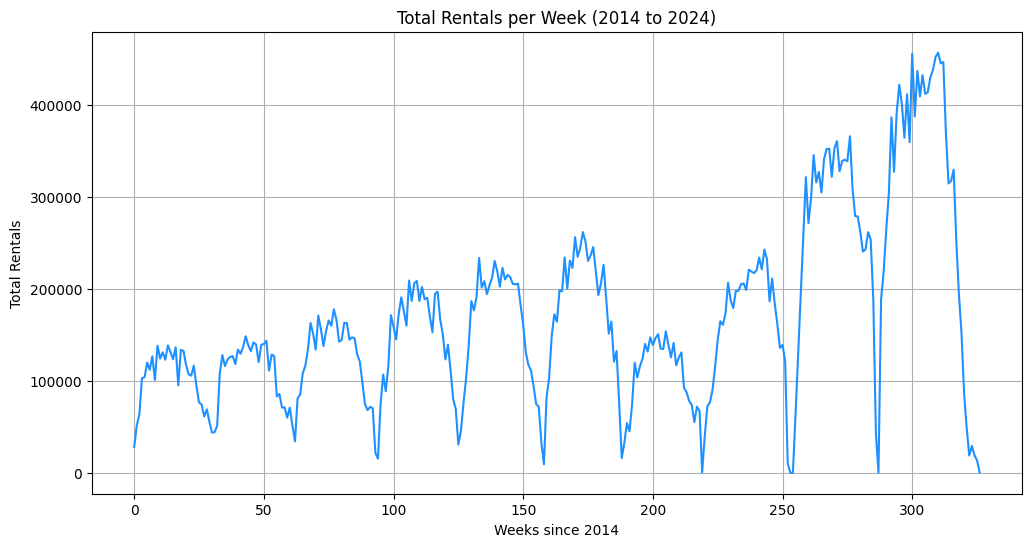

In [56]:


# Directory containing the CSV files
data_folder = '../Data'

# List to store DataFrames from each CSV file
dfs = []

# Iterate over files in the folder
for filename in os.listdir(data_folder):
    # Check if the file is a CSV and its name corresponds to a year from 2014 to 2024
    if filename.endswith('.csv') and filename.split('.')[0].isdigit():
        year = int(filename.split('.')[0])
        if 2014 <= year <= 2024:
            # Read the CSV file into a DataFrame and append it to the list
            df = pd.read_csv(os.path.join(data_folder, filename))
            dfs.append(df)

# Concatenate all DataFrames into a single DataFrame
data = pd.concat(dfs, ignore_index=True)

data['STARTTIMEMS'] = pd.to_datetime(data['STARTTIMEMS'], unit='ms')

# Extract week number from the STARTTIMEMS column
data['Week'] = data['STARTTIMEMS'].dt.isocalendar().week
data['Year'] = data['STARTTIMEMS'].dt.year

# Group by Week and Year to compute the total number of rentals per week
weekly_rentals = data.groupby(['Year', 'Week']).size().reset_index(name='TotalRentals')

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(weekly_rentals.index, weekly_rentals['TotalRentals'], color='#1E90FF', linestyle='-')
plt.xlabel('Weeks since 2014')
plt.ylabel('Total Rentals')
plt.title('Total Rentals per Week (2014 to 2024)')
plt.grid(True)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


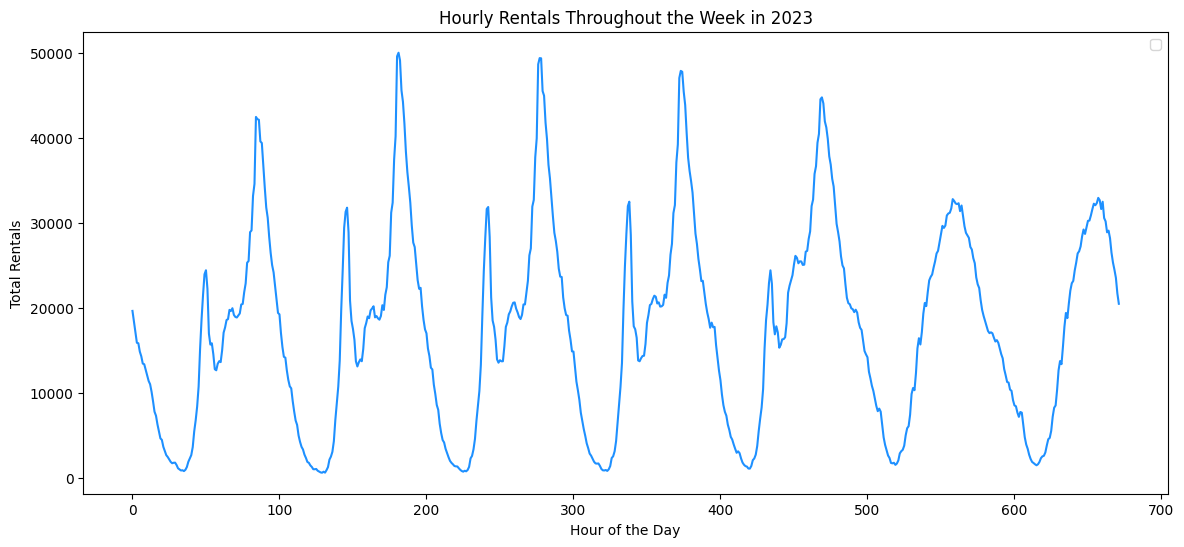

In [66]:
data = pd.read_csv('../Data/2023.csv')

# Convert STARTTIMEMS to datetime objects
data['STARTTIMEMS'] = pd.to_datetime(data['STARTTIMEMS'], unit='ms')

# Extract hour and day of the week information from the STARTTIMEMS column
data['QuarterHour'] = (data['STARTTIMEMS'].dt.hour * 4) + (data['STARTTIMEMS'].dt.minute // 15)
data['DayOfWeek'] = data['STARTTIMEMS'].dt.dayofweek  # Monday=0, Sunday=6

# Group by QuarterHour and Day of the week to compute the total number of rentals for each quarter-hour of each day
quarter_hourly_rentals = data.groupby(['DayOfWeek', 'QuarterHour']).size().reset_index(name='TotalRentals')

# Plotting
plt.figure(figsize=(14, 6))

plt.plot(quarter_hourly_rentals.index, quarter_hourly_rentals['TotalRentals'], color='#1E90FF', linestyle='-')

plt.xlabel('Hour of the Day')
plt.ylabel('Total Rentals')
plt.title('Hourly Rentals Throughout the Week in 2023')
plt.grid(True)
plt.show()

<Figure size 1200x1000 with 0 Axes>

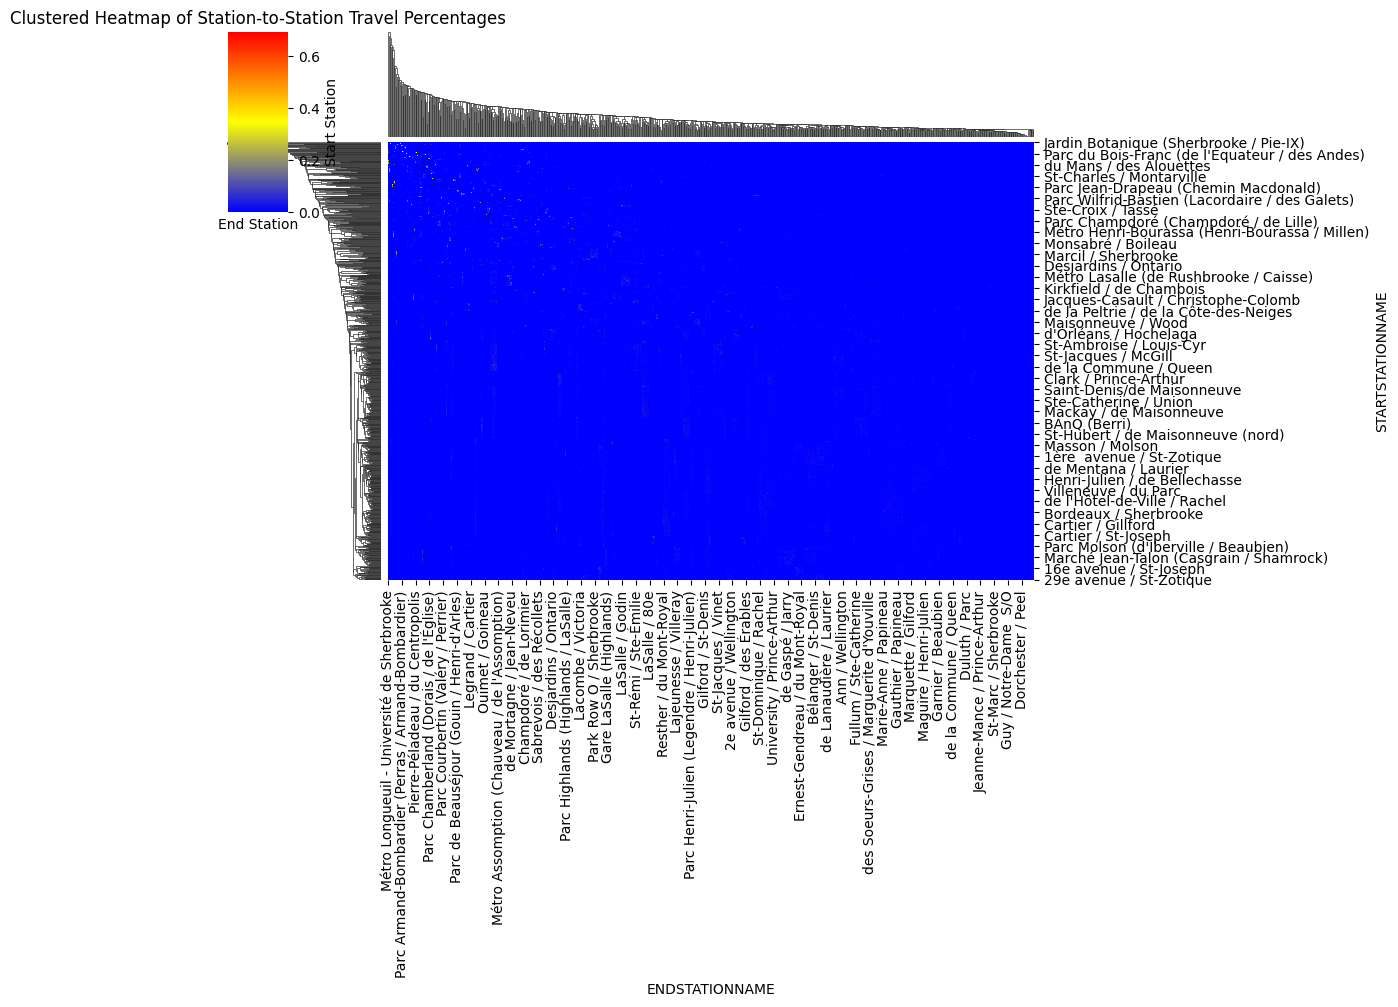

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.cluster import hierarchy

# Assuming your dataset is in a CSV file named 'bike_data.csv'
data = pd.read_csv('../Data/2023.csv')

# Compute the total departures from each station
total_departures = data.groupby('STARTSTATIONNAME').size()

# Compute the percentage of departures from each station that arrive at every other station
station_to_station_percentages = pd.pivot_table(data, index='STARTSTATIONNAME', columns='ENDSTATIONNAME', aggfunc='size', fill_value=0) / total_departures.values[:, None]

station_to_station_percentages_log = np.log1p(station_to_station_percentages)

# Hierarchical clustering
row_linkage = hierarchy.linkage(station_to_station_percentages_log.values, method='average')
col_linkage = hierarchy.linkage(station_to_station_percentages_log.values.T, method='average')


colors = ['#0000FF', '#FFFF00', '#FF0000']

# Create a colormap with a smooth transition from blue to yellow to red
cmap = mcolors.LinearSegmentedColormap.from_list('blue_yellow_red', colors)
# Plotting the clustered heatmap
plt.figure(figsize=(12, 10))
sns.clustermap(station_to_station_percentages_log, row_linkage=row_linkage, col_linkage=col_linkage, cmap=cmap, figsize=(12, 10))
plt.title('Clustered Heatmap of Station-to-Station Travel Percentages')
plt.xlabel('End Station')
plt.ylabel('Start Station')
plt.show()

c:\Users\Chaubi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Chaubi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Chaubi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Chaubi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\

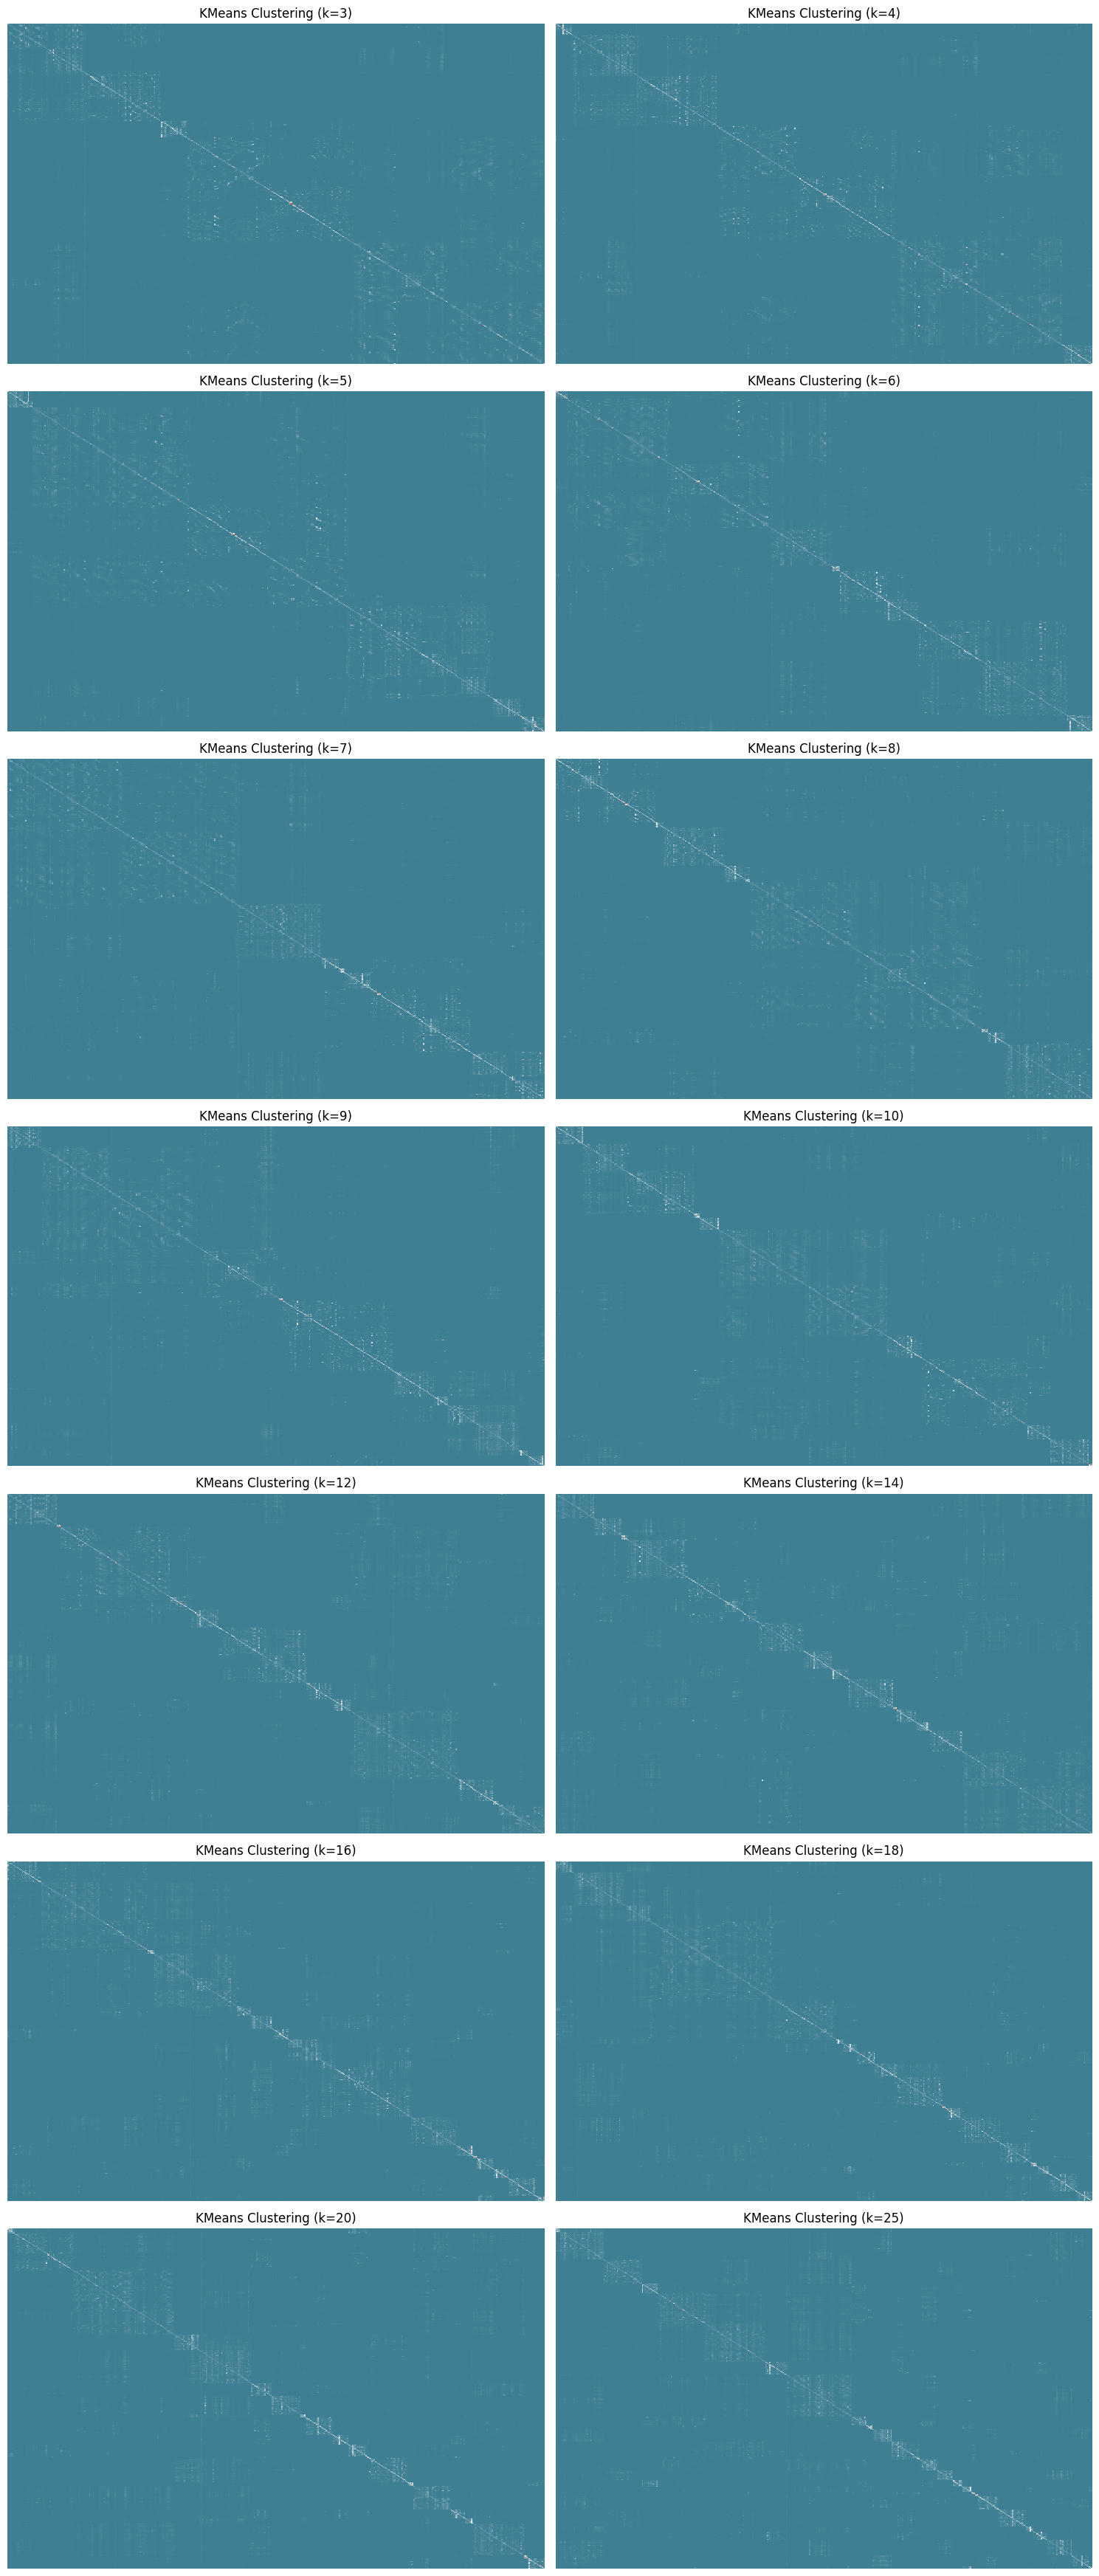

In [41]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster import hierarchy
from sklearn.cluster import KMeans

# Assuming your dataset is in a CSV file named 'bike_data.csv'
data = pd.read_csv('../Data/2023.csv')

# data = data[pd.notnull(data['STARTSTATIONLATITUDE']) & pd.notnull(data['STARTSTATIONLONGITUDE']) & pd.notnull(data['ENDSTATIONLATITUDE']) & pd.notnull(data['ENDSTATIONLONGITUDE'])]
data.dropna(how='any')

latitude_min = min(data['STARTSTATIONLATITUDE'].min(), data['ENDSTATIONLATITUDE'].min())
latitude_max = max(data['STARTSTATIONLATITUDE'].max(), data['ENDSTATIONLATITUDE'].max())
longitude_min = min(data['STARTSTATIONLONGITUDE'].min(), data['ENDSTATIONLONGITUDE'].min())
longitude_max = max(data['STARTSTATIONLONGITUDE'].max(), data['ENDSTATIONLONGITUDE'].max())

# Define the number of bins
num_bins = 10000

# Define the boundaries of latitude and longitude bins
latitude_bins = np.linspace(latitude_min, latitude_max, num_bins)
longitude_bins = np.linspace(longitude_min, longitude_max, num_bins)

# Assign stations to latitude and longitude squares
data['StartSquare'] = pd.cut(data['STARTSTATIONLATITUDE'], bins=latitude_bins).astype(str) + '_' + pd.cut(data['STARTSTATIONLONGITUDE'], bins=longitude_bins).astype(str)
data['EndSquare'] = pd.cut(data['ENDSTATIONLATITUDE'], bins=latitude_bins).astype(str) + '_' + pd.cut(data['ENDSTATIONLONGITUDE'], bins=longitude_bins).astype(str)

# Compute the total departures from each square
total_departures = data.groupby(['StartSquare']).size()

# Compute the percentage of departures between stations within each square
station_to_station_percentages = pd.pivot_table(data, index=['StartSquare'], columns='EndSquare', aggfunc='size', fill_value=0) / total_departures.values[:, None]
station_to_station_percentages_log = np.log1p(station_to_station_percentages)
# Hierarchical clustering
# row_linkage = hierarchy.linkage(station_to_station_percentages.values, method='average')
# col_linkage = hierarchy.linkage(station_to_station_percentages.values.T, method='average')
# Perform KMeans clustering
k_values = [3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 18, 20, 25]  # You can adjust this list with the values of k you want to test
num_plots = len(k_values)

# Create subplots with 2 plots per row
num_rows = (num_plots + 1) // 2
fig, axes = plt.subplots(num_rows, 2, figsize=(15, 5 * num_rows))

custom_palette = sns.diverging_palette(220, 20, as_cmap=True)

for i, k in enumerate(k_values):
    row = i // 2
    col = i % 2
    # Perform KMeans clustering
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(station_to_station_percentages_log)
    sorted_idx = np.argsort(clusters)
    sorted_columns = station_to_station_percentages_log.columns[sorted_idx]
    sorted_rows = station_to_station_percentages_log.index[sorted_idx]
    sorted_percentages = station_to_station_percentages_log.reindex(index=sorted_rows, columns=sorted_columns)
    
    # Plot the clustered heatmap
    sns.heatmap(sorted_percentages, cmap=custom_palette, ax=axes[row, col], cbar=False)
    axes[row, col].set_title(f'KMeans Clustering (k={k})')
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

In [19]:
dtype_dict = {
    'STARTTIMEMS': np.int64,
    'ENDTIMEMS': np.int64
}

data = pd.read_csv('../Data/2023.csv').dropna(how='any').astype(dtype_dict)

In [32]:
#from ipyleaflet import Map, TileLayer

# Create a map centered around Montreal
data['STARTTIMEMS'] = pd.to_datetime(data['STARTTIMEMS'], unit='ms')
data['ENDTIMEMS'] = pd.to_datetime(data['ENDTIMEMS'], unit='ms')
data = data[data['STARTTIMEMS'].dt.dayofweek < 5]  # Assuming Monday is 0 and Friday is 4

# Create a map for each hour between 5 am and 11 pm
for hour in range(5, 24):
    # Filter data for the current hour
    # print(data['STARTTIMEMS'])
    departure_data = data[data['STARTTIMEMS'].dt.hour == hour]
    arrival_data = data[data['ENDTIMEMS'].dt.hour == hour]
    # print(departure_data)
    # Compute sum of arrivals and departures for the current hour
    departure_counts = departure_data.groupby(['STARTSTATIONLATITUDE', 'STARTSTATIONLONGITUDE', 'STARTSTATIONNAME']).size()
    arrival_counts = arrival_data.groupby(['ENDSTATIONLATITUDE', 'ENDSTATIONLONGITUDE', 'ENDSTATIONNAME']).size()
    # print("departure_counts", departure_counts)

    scaler = MinMaxScaler(feature_range=(5, 20))  # Define the desired range for the radius
    departure_radius = scaler.fit_transform(departure_counts.values.reshape(-1, 1)).flatten()
    arrival_radius = scaler.fit_transform(arrival_counts.values.reshape(-1, 1)).flatten()

    # Create a map centered around Montreal
    montreal_center = [45.5017, -73.5673]
    mymap = Map(center=montreal_center, zoom=12)
    
    # Add OpenTopoMap tiles to the map
    opentopomap_layer = TileLayer(url="https://{s}.tile.opentopomap.org/{z}/{x}/{y}.png", attribution="Map data: &copy; OpenTopoMap")
    mymap.add_layer(opentopomap_layer)
    
    # Add markers for arrivals and departures
    for (lat, lon, name), radius in zip(departure_counts.index, departure_radius):
        mymap.add_layer(CircleMarker(location=(lat, lon), radius=int(radius), color='blue', fill_opacity=0.3))
    
    # Add markers for arrivals
    for (lat, lon, name), radius in zip(arrival_counts.index, arrival_radius):
        mymap.add_layer(CircleMarker(location=(lat, lon), radius=int(radius), color='green', fill_opacity=0.3))

    # Display the map
    print(f"Map for {hour}:00")
    display(mymap)

Map for 5:00


Map(center=[45.5017, -73.5673], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'z…

Map for 6:00


Map(center=[45.5017, -73.5673], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'z…

Map for 7:00


Map(center=[45.5017, -73.5673], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'z…

KeyboardInterrupt: 